# Extracting Important Frames from the Video

In [1]:
from frame_detector import extract_frames, find_move, compute_edge_mean
from board_warper import warp_chessboard, get_closest_tile
from pgn_converter import moves_to_pgn, is_valid_move
import cv2
import os
import shutil
from ultralytics import YOLO
import chess
import chess.svg
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import SVG, display
import csv
video_paths = {
    n: f"cu-chess-detection-2025\\Chess Detection Competition\\test_videos\\{n}_move_student.mp4"
    for n in [2, 4, 6, 8]
}
video_paths["2_rotate"] = "cu-chess-detection-2025\\Chess Detection Competition\\test_videos\\2_move_rotate_student.mp4"
video_paths["bonus"] = "cu-chess-detection-2025\\Chess Detection Competition\\bonus_video\\Bonus Long Video Label.mp4"
ref = cv2.imread("ref.jpg")
centers = {(0, 0): (148, 148), (0, 1): (148, 251), (0, 2): (148, 354), (0, 3): (148, 457), (0, 4): (148, 560), (0, 5): (148, 663), (0, 6): (148, 766), (0, 7): (148, 869), (1, 0): (251, 148), (1, 1): (251, 251), (1, 2): (251, 354), (1, 3): (251, 457), (1, 4): (251, 560), (1, 5): (251, 663), (1, 6): (251, 766), (1, 7): (251, 869), (2, 0): (354, 148), (2, 1): (354, 251), (2, 2): (354, 354), (2, 3): (354, 457), (2, 4): (354, 560), (2, 5): (354, 663), (2, 6): (354, 766), (2, 7): (354, 869), (3, 0): (457, 148), (3, 1): (457, 251), (3, 2): (457, 354), (3, 3): (457, 457), (3, 4): (457, 560), (3, 5): (457, 663), (3, 6): (457, 766), (3, 7): (457, 869), (4, 0): (560, 148), (4, 1): (560, 251), (4, 2): (560, 354), (4, 3): (560, 457), (4, 4): (560, 560), (4, 5): (560, 663), (4, 6): (560, 766), (4, 7): (560, 869), (5, 0): (663, 148), (5, 1): (663, 251), (5, 2): (663, 354), (5, 3): (663, 457), (5, 4): (663, 560), (5, 5): (663, 663), (5, 6): (663, 766), (5, 7): (663, 869), (6, 0): (766, 148), (6, 1): (766, 251), (6, 2): (766, 354), (6, 3): (766, 457), (6, 4): (766, 560), (6, 5): (766, 663), (6, 6): (766, 766), (6, 7): (766, 869), (7, 0): (869, 148), (7, 1): (869, 251), (7, 2): (869, 354), (7, 3): (869, 457), (7, 4): (869, 560), (7, 5): (869, 663), (7, 6): (869, 766), (7, 7): (869, 869)}

In [2]:
for k, v in video_paths.items():
    print(f"Extracting: k = {k}...")
    first_frame, extracted_frames = extract_frames(v, ref=ref, centers=centers)

    output_dir = f"storage/extracted_Frames_{k}"
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir, exist_ok=True)

    for i, frame in enumerate(extracted_frames):
        filename = f"frame_{i:04d}.png"
        cv2.imwrite(os.path.join(output_dir, filename), frame)
print("Frame Extraction Finished!")


Extracting: k = bonus...
Frame Extraction Finished!


# Defining the Board Class

In [2]:
class Board:
    def __init__(self, model, first_frame, tile_centers, ref):
        self.model = model
        self.tile_centers = tile_centers
        self.current_frame = first_frame
        self.ref = ref
        pred = model(first_frame, verbose=False)[0]

        self.piece_positions = {}
        
        for box in pred.boxes:
            # Bounding box coordinates
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            
            # Center of the bounding box
            cx = (x1 + x2) / 2
            cy = (y1 + y2) / 2

            # Class ID → label
            cls_id = int(box.cls[0])
            label = pred.names[cls_id]

            # Find best tile based on center
            tile = get_closest_tile(cx, cy, tile_centers)

            if tile is not None:
                self.piece_positions[tile] = label
    def _to_square(self, row, col):
        """
        Your board:
        (0,0) top-left = h1
        (7,7) bottom-right = a8

        Mapping:
            file = 7 - col
            rank = row
        """
        file = 7 - col
        rank = row
        return chess.square(file, rank)

    def print_svg(self, size=350):
        """
        Build a python-chess board from self.piece_positions and return SVG.
        Optionally save SVG to file.
        """
        # Empty board (None means start from blank)
        board = chess.Board(None)
        # Mapping YOLO labels → python-chess piece types
        label_to_piece = {
            "w_pawn": chess.PAWN,
            "w_knight": chess.KNIGHT,
            "w_bishop": chess.BISHOP,
            "w_rook": chess.ROOK,
            "w_queen": chess.QUEEN,
            "w_king": chess.KING,

            "b_pawn": chess.PAWN,
            "b_knight": chess.KNIGHT,
            "b_bishop": chess.BISHOP,
            "b_rook": chess.ROOK,
            "b_queen": chess.QUEEN,
            "b_king": chess.KING,
        }

        # Add each piece to the board
        for (row, col), label in self.piece_positions.items():
            piece_type = label_to_piece[label]
            color = label.startswith("w")
            sq = self._to_square(row, col)
            board.set_piece_at(sq, chess.Piece(piece_type, color))

        # Generate SVG
        svg = chess.svg.board(board=board, size=size)

        return svg
    def move_board(self, frame_after):
        """
        Attempt to detect move using diff-based method first.
        If it fails or gives inconsistent results, fallback to YOLO re-detection.
        """
        killed = None

        # ---------------------------------------------
        # 1. Try your existing detection logic first
        # ---------------------------------------------
        try:
            detected_move, _ = find_move(
                self.current_frame, frame_after,
                self.tile_centers,
                warped=True,
                ref=self.ref,
                MIN_AREA=200
            )
            #print(detected_move)
            # detected_move must be two tiles
            if detected_move is None or len(detected_move) != 2:
                raise ValueError("find_move returned invalid result")

            centers = self.tile_centers
            center0 = centers[detected_move[0]]
            center1 = centers[detected_move[1]]

            mean_edges = np.array([
                compute_edge_mean(center0, frame_after)[0],
                compute_edge_mean(center1, frame_after)[0]
            ])
            idx = np.argmin(mean_edges)

            before_move = detected_move[idx]
            after_move = detected_move[1 - idx]

            # basic consistency check:
            if before_move not in self.piece_positions:
                raise ValueError("find_move gave a non-piece tile")
            m_piece = self.piece_positions[before_move]
            c, piece_type = m_piece.split("_")
            color = c == "b"

            # Perform move
            if after_move in self.piece_positions:
                if self.piece_positions[before_move].split("_")[0] == self.piece_positions[after_move].split("_")[0]:
                    raise ValueError(f"Cannot capture chess piece on the same team")
                if is_valid_move(piece_type, before_move, after_move, color, capture = True) == False:
                    raise ValueError("Invalid move")
                killed = self.piece_positions.pop(after_move)
            else:
                if is_valid_move(piece_type, before_move, after_move, color) == False:
                    raise ValueError("Invalid move")
        
            moved_piece = self.piece_positions.pop(before_move)
            self.piece_positions[after_move] = moved_piece

            # Update frame
            self.current_frame = frame_after

            return moved_piece, before_move, after_move, killed

        except Exception as e:
            print("[WARN] find_move failed, falling back to YOLO detection:", e)

        # ---------------------------------------------------------
        # 2. FALLBACK: Re-detect all pieces from the model
        # ---------------------------------------------------------
        pred = self.model(frame_after, verbose=False)[0]
        new_positions = {}

        for box in pred.boxes:
            # Bounding box coordinates
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            
            # Center of the bounding box
            cx = (x1 + x2) / 2
            cy = (y1 + y2) / 2

            # Class ID → label
            cls_id = int(box.cls[0])
            label = pred.names[cls_id]

            # Find best tile based on center
            tile = get_closest_tile(cx, cy, self.tile_centers)

            if tile is not None:
                new_positions[tile] = label

        # ---------------------------------------------------------
        # 3. Compare old vs new to detect move
        # ---------------------------------------------------------
        old = self.piece_positions
        new = new_positions

        disappeared = [sq for sq in old if sq not in new]
        appeared = [sq for sq in new if sq not in old]
        changed = [sq for sq in new if sq in old and new[sq] != old[sq]]

        moved_piece = None
        before_move = None
        after_move = None
        killed = None

        # --- Case 1: normal move (no capture) ---
        if len(disappeared) >= 1 and len(appeared) == 1:
            
            #before_move = disappeared[0]
            after_move = appeared[0]
            moved_piece = new[after_move]
            # Find which disappeared square had this piece before the move
            #print(old[(5,3)])
            candidates = [sq for sq in disappeared if old[sq] == moved_piece]

            if len(candidates) != 1:
                raise RuntimeError(
                    f"Ambiguous normal move: disappeared={disappeared}, moved_piece={moved_piece}"
                )

            before_move = candidates[0]

            # Update Board
            self.piece_positions.pop(before_move)
            self.piece_positions[after_move] = moved_piece
        # --- Case 2: capture ---
        elif len(disappeared) >= 1 and len(changed) == 1:
            after_move = changed[0]
            moved_piece = new[after_move]
            killed = old[after_move]  # old piece at destination
            
            # Find which disappeared square had this piece before the move
            candidates = [sq for sq in disappeared if old[sq] == moved_piece]

            if len(candidates) != 1:
                raise RuntimeError(
                    f"Ambiguous normal move: disappeared={disappeared}, moved_piece={moved_piece}"
                )

            before_move = candidates[0]

            # Update Board
            self.piece_positions.pop(before_move)
            self.piece_positions[after_move] = moved_piece
        # --- Anything else = ambiguous ---
        else:
            self.current_frame = frame_after
            #self.piece_positions = new_positions
            return None, None, None, None
            #raise RuntimeError(f"Fallback detection ambiguous: disappeared={disappeared}, appeared={appeared}, changed={changed}")
            
        # ---------------------------------------------------------
        # 4. Apply final board update
        # ---------------------------------------------------------
        #self.piece_positions = new_positions
        self.current_frame = frame_after

        return moved_piece, before_move, after_move, killed
        

# Prediction

## Single video prediction

In [3]:
model = YOLO("model/best.pt")  
def predict_video(extracted_frames, show_output = True):
    first_frame = extracted_frames[0]

    board = Board(model, first_frame, centers, ref)
    if show_output == True:
        svg = board.print_svg(size=350)
        display(SVG(svg))
    
    # Running moves
    moves = []
    for i, move in enumerate(extracted_frames[1:], start=1):
        moved_piece, before_move, after_move, killed = board.move_board(move)
        if moved_piece != None:
            moves.append((moved_piece, before_move, after_move, killed)) #killed = b_pawn
        else:
            print(f"(Move {i}) ERROR: Skipping...")
            continue
        if killed == None:
            if show_output == True:
                print(f"(Move {i}) {moved_piece}: {before_move} -> {after_move}")
        else:
            if show_output == True:
                print(f"(Move {i}) {moved_piece}: {before_move} -> {after_move} (killed: {killed})")
    
    pgn = moves_to_pgn(moves)
    if show_output == True:
        print(pgn)
    return pgn      


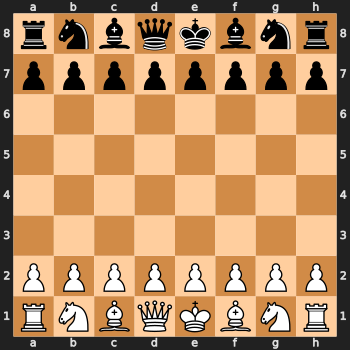

(Move 1) w_pawn: (1, 2) -> (3, 2)
(Move 2) b_pawn: (6, 4) -> (4, 4)
(Move 3) w_knight: (0, 1) -> (2, 2)
(Move 4) b_bishop: (7, 5) -> (4, 2)
[WARN] find_move failed, falling back to YOLO detection: find_move gave a non-piece tile
(Move 5) w_knight: (0, 6) -> (2, 5)
(Move 6) b_knight: (7, 6) -> (5, 5)
(Move 7) w_knight: (2, 5) -> (4, 4) (killed: b_pawn)
(Move 8) b_pawn: (6, 3) -> (5, 3)
(Move 9) w_knight: (4, 4) -> (2, 3)
[WARN] find_move failed, falling back to YOLO detection: Cannot capture chess piece on the same team
(Move 10) ERROR: Skipping...
(Move 11) b_queen: (7, 4) -> (3, 0)
(Move 12) w_knight: (2, 2) -> (3, 0) (killed: b_queen)
(Move 13) b_knight: (7, 1) -> (5, 0)
(Move 14) w_knight: (3, 0) -> (4, 2) (killed: b_bishop)
[WARN] find_move failed, falling back to YOLO detection: Cannot capture chess piece on the same team
(Move 15) ERROR: Skipping...
(Move 16) b_knight: (5, 0) -> (4, 2) (killed: w_knight)
(Move 17) w_knight: (2, 3) -> (4, 2) (killed: b_knight)
(Move 18) b_pawn: (5

In [6]:
folder = "storage\\extracted_Frames_bonus"
extracted_frames = []
for filename in os.listdir(folder):
    filepath = os.path.join(folder, filename)
    img = cv2.imread(filepath)
    extracted_frames.append(img)
pgn = predict_video(extracted_frames)

## All video prediction

In [4]:
video_name = {2:"2_move_student.mp4",
              4:"4_Move_studet.mp4",
              6:"6_Move_student.mp4", 
              8:"8_Move_student.mp4", 
              "2_rotate":"2_Move_rotate_student.mp4", 
              "bonus": "(Bonus)Long_video_student.mp4"}
output_rows = []  # To store (row_id, pgn)
for k in video_paths.keys():
    folder_path = f"storage\\extracted_Frames_{k}"
    # print(folder_path)
    extracted_frames = []
    for filename in os.listdir(folder_path):
        filepath = os.path.join(folder_path, filename)
        img = cv2.imread(filepath)
        extracted_frames.append(img)
    pgn = predict_video(extracted_frames, show_output=False)
    output_rows.append([video_name[k], pgn])

# Write CSV
csv_path = "video_results.csv"
with open(csv_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["row_id", "output"])   # header
    writer.writerows(output_rows)

print("CSV created:", csv_path)

[WARN] find_move failed, falling back to YOLO detection: Invalid move
[WARN] find_move failed, falling back to YOLO detection: Cannot capture chess piece on the same team
[WARN] find_move failed, falling back to YOLO detection: find_move gave a non-piece tile
[WARN] find_move failed, falling back to YOLO detection: Cannot capture chess piece on the same team
(Move 10) ERROR: Skipping...
[WARN] find_move failed, falling back to YOLO detection: Cannot capture chess piece on the same team
(Move 15) ERROR: Skipping...
[WARN] find_move failed, falling back to YOLO detection: Cannot capture chess piece on the same team
[WARN] find_move failed, falling back to YOLO detection: Cannot capture chess piece on the same team
(Move 24) ERROR: Skipping...
[WARN] find_move failed, falling back to YOLO detection: Cannot capture chess piece on the same team
(Move 27) ERROR: Skipping...
[WARN] find_move failed, falling back to YOLO detection: Cannot capture chess piece on the same team
(Move 32) ERROR: S